## Importing liabraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import pathlib
import tensorflow as tf
from tensorflow import keras
import os
from tqdm import tqdm
import time

Define the input zip path and output unzip path

In [2]:
base_dir = '/kaggle/input/data-science-bowl-2018/'
unzip_base_dir = '/kaggle/working/'
stage_train_zip = base_dir + 'stage1_train.zip'
stage_train_labels_zip= base_dir + 'stage1_train_labels.csv.zip'

stage_train_unzip = unzip_base_dir + 'stage1_train/'
stage_train_labels_unzip= unzip_base_dir + 'stage1_train_labels/'

## 1) Unzip the data

In [3]:
import zipfile
for path, unzip_path in zip([stage_train_zip,stage_train_labels_zip ], [stage_train_unzip, stage_train_labels_unzip]):
    print(path)
    print(unzip_path)
    print('---')
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/working/stage1_train/
---
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/working/stage1_train_labels/
---


In [4]:
test_data = r"/kaggle/input/data-science-bowl-2018/stage1_test.zip"
test_data_unzip = unzip_base_dir + 'stage1_test/'
with zipfile.ZipFile(test_data, 'r') as zip_ref:
    zip_ref.extractall(test_data_unzip)

In [5]:
test = pathlib.Path(test_data_unzip)
lsttest_files = glob.glob(str(test/'*/'))
lsttest_files[:10]

['/kaggle/working/stage1_test/4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac',
 '/kaggle/working/stage1_test/7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04',
 '/kaggle/working/stage1_test/336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523',
 '/kaggle/working/stage1_test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4',
 '/kaggle/working/stage1_test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b',
 '/kaggle/working/stage1_test/648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9',
 '/kaggle/working/stage1_test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d',
 '/kaggle/working/stage1_test/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078',
 '/kaggle/working/stage1_test/43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af',
 '/kaggle/working/stage1_test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580']

This function is just to get an image given path, So for test purpose we will use this function to get test image

In [6]:
def get_image(image_path):
    temp_path = glob.glob(image_path+'/images/*')
    img = tf.io.read_file(temp_path[0])
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, (128,128))

    arr = img[:, :, :3].numpy()
    new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min())))
    return new_arr

test_images = []
for i in lsttest_files:
    test_images.append(get_image(i))

2021-12-31 17:43:07.545866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 17:43:07.646607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 17:43:07.647278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 17:43:07.650195: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
# We will convert test images to the tensor
test_dataset = tf.convert_to_tensor(np.array(test_images))

let's have all filepath of images in list

In [8]:
path = pathlib.Path(stage_train_unzip)
lst_files = glob.glob(str(path/'*/'))

In [9]:
BATCH_SIZE = 64

This class will create dataset for training,As we know by using this type of class, It is computationally expensive. So for just demostration purpose i am using this class to pass data to the model

In [10]:
class create_ds(keras.utils.Sequence):
    def __init__(self, lst_files, batch_size):
        self.lst_files = lst_files
        self.batch_size = batch_size
        
    def __len__(self):
        return len(self.lst_files)//self.batch_size

    
    def get_image(self, image_path):
        temp_path = glob.glob(image_path+'/images/*')
        img = tf.io.read_file(temp_path[0])
        img = tf.io.decode_image(img)
        img = tf.image.resize(img, (128,128))

        arr = img[:, :, :3].numpy()
        new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min())))
        
        ma = glob.glob(image_path+'/masks/*')
        mask_ = tf.zeros(shape = (128, 128, 1))
        
        # Get all mask in particular folder and append to mask with all pixel value equal to zero
        for mask_path in ma:
            mask = tf.io.read_file(mask_path)
            mask = tf.io.decode_image(mask)
            mask = tf.image.resize(mask, (128,128))
           
            mask_ = tf.maximum(mask_, mask)
        
        return new_arr, mask_.numpy()
        
    # Create batches of given batch and return to the dataset object    
    def __getitem__(self, idx):
        batch = self.lst_files[idx * self.batch_size : (idx+1)*self.batch_size]
        
        temp_image = []
        temp_label = []
        for path in batch:
            new_arr, mask = self.get_image(path)
            temp_image.append(new_arr)
            temp_label.append(mask/255.0)
        
        return tf.convert_to_tensor(np.array(temp_image), dtype='float32'), tf.convert_to_tensor(np.array(temp_label),dtype ='float32')
    

Function to plot the 

In [11]:
import plotly.graph_objects as go

# We will pass the df which we created using model.history, So we wo=ill plot train, test loss. Train test accuracy
def plot_train_valid_curcve(df):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=list(range(len(df))), y=df['loss'],
                            mode='lines',
                            name='Train_loss'))

        fig.add_trace(go.Scatter(x=list(range(len(df))), y=df['val_loss'],
                            mode='lines',
                            name='val_loss'))

        fig.add_trace(go.Scatter(x=list(range(len(df))), y=df['accuracy'],
                            mode='lines',
                            name='Train_accuracy'))

        fig.add_trace(go.Scatter(x=list(range(len(df))), y=df['val_accuracy'],
                            mode='lines',
                            name='val_accuracy'))
        fig.show()
        
# Let's see what we got as a prediction
def plot_predicted_image(x_test, valid, pred):
    ''' Function to plot Actual image, actual mask, Predicted Mask
    
    Param X-test : Actual image
    Param valid  : Validation mask
    Param pred   : Predicted image
    '''
    
    fig = plt.figure(figsize = (15,7))
    plt.subplot(1, 3,1)
    plt.title('Actual Image')
    plt.imshow(x_test)
    
#     fig = plt.figure(figsize = (20,7))
    plt.subplot(1, 3,2)
    plt.title('Actual Mask')
    plt.imshow(valid)
    
    plt.subplot(1, 3,3)
    plt.title('Predicted mask')
    plt.imshow(pred)

In [12]:
# let's split the data into train test split
from sklearn.model_selection import train_test_split
train, valid = train_test_split(lst_files)

In [13]:
# Creating the data using the class we created where we leverage the functionality of keras.sequence
train_ds = create_ds(lst_files=train, batch_size = BATCH_SIZE) 
valid_ds= create_ds(lst_files=valid, batch_size = BATCH_SIZE)

## Create model

In [14]:
# the dimension of image
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
CHANNEL = 3

get_model will give us model with Unet. One point to be noted here we have used padding as same, If we read the architecture carefully they are using 
different concatenationa as well as loss function. For this notebook we will get overview of unet

In [15]:
def get_model(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL):
    inputs = keras.Input(shape = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL))
    conv_1 = keras.layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation='relu')(inputs)
    conv_1 = keras.layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation='relu')(conv_1)
    # conv_1

    conv_2 = keras.layers.MaxPool2D(pool_size = (2,2))(conv_1)
    conv_2 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation='relu')(conv_2)

    conv_3 = keras.layers.MaxPool2D(pool_size = (2,2))(conv_2)
    conv_3 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation='relu')(conv_3)

    conv_4 = keras.layers.MaxPool2D(pool_size = (2,2))(conv_3)
    conv_4 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation='relu')(conv_4)

    conv_5 = keras.layers.MaxPool2D(pool_size = (2,2))(conv_4)
    conv_5 = keras.layers.Conv2D(filters = 256, kernel_size = 3, padding='same', activation='relu')(conv_5)
    conv_5 = keras.layers.Conv2D(filters = 256, kernel_size = 3, padding='same', activation='relu')(conv_5)
    
    conv_6 = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 2, strides = 2, padding='same')(conv_5)
    conv_6 = keras.layers.concatenate([conv_4, conv_6])
    conv_6 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation='relu')(conv_6)
    conv_6 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation='relu')(conv_6)

    conv_7 = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 2, strides = 2, padding='same')(conv_6)
    conv_7 = keras.layers.concatenate([conv_3, conv_7])
    conv_7 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation='relu')(conv_7)
    conv_7 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation='relu')(conv_7)

    conv_8 = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 2, strides = 2, padding='same')(conv_7)
    conv_8 = keras.layers.concatenate([conv_2, conv_8])
    conv_8 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation='relu')(conv_8)
    conv_8 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding='same', activation='relu')(conv_8)


    conv_9 = keras.layers.Conv2DTranspose(filters = 16, kernel_size = 2, strides = 2, padding='same')(conv_8)
    conv_9 = keras.layers.concatenate([conv_1, conv_9])
    conv_9 = keras.layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation='relu')(conv_9)
    conv_9 = keras.layers.Conv2D(filters = 16, kernel_size = 3, padding='same', activation='relu')(conv_9)

    output = keras.layers.Conv2D(filters = 1, kernel_size = 3, padding='same', activation='relu')(conv_9)
    model = keras.Model(inputs, output)
    return model

In [16]:
model = get_model(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [18]:
# We will create baseline model and execute for 10 epochs

start = time.time()
history = model.fit(train_ds, validation_data=valid_ds, epochs = 10, verbose=False)

end = time.time()
print(f'Time required for the execution is {end - start}')

2021-12-31 17:43:40.274755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-31 17:43:48.141419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Time required for the execution is 509.72328782081604


In [19]:
df = pd.DataFrame(history.history)

In [20]:
plot_train_valid_curcve(df)

## 2) Create data pipeline using tensor slices

As we have seen previous data pipeline was taking too much time for each epoch so we will use tf.data.Dataset object

In [22]:
model = get_model(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL)

In [23]:
# As we have already created class through which we can call image and mask, We will write for loop and create data pipeline ,
# Let's see if we can spped up the processing.

x_train_slices = []
y_train_slices = []

x_test_slices = []
y_test_slices = []

for (train, train_label)  in tqdm(train_ds):
    for x_train, y_train in zip(train, train_label):
        x_train_slices.append(x_train.numpy())
        y_train_slices.append(y_train.numpy())
        
for (valid, valid_label)  in tqdm( valid_ds):
    for  x_test, y_test in zip( valid, valid_label):
        
        x_test_slices.append(x_test.numpy())
        y_test_slices.append(y_test.numpy())

100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


In [24]:
train_tensor_ds = tf.data.Dataset.from_tensor_slices((x_train_slices, y_train_slices))
valid_tensor_ds = tf.data.Dataset.from_tensor_slices((x_test_slices, y_test_slices))

In [25]:
BATCH_SIZE = 64
train_tensor_ds = train_tensor_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
valid_tensor_ds = valid_tensor_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## Model 2

As we can see from the time required  to train the model is significantly reduced

In [26]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [27]:

start = time.time()
history = model.fit(train_tensor_ds, validation_data = valid_tensor_ds, epochs = 100, verbose=False)

end = time.time()

print(f'Time required for the execution is {end - start}')

Time required for the execution is 75.61661410331726


In [28]:
df = pd.DataFrame(history.history)

In [29]:
plot_train_valid_curcve(df)

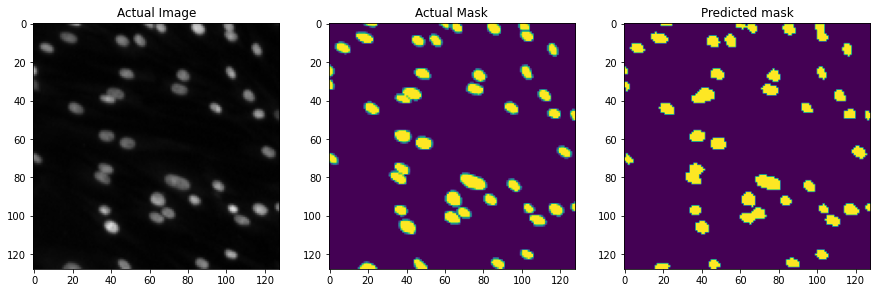

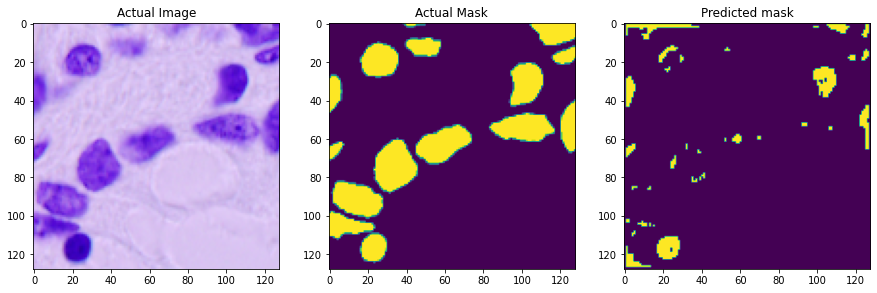

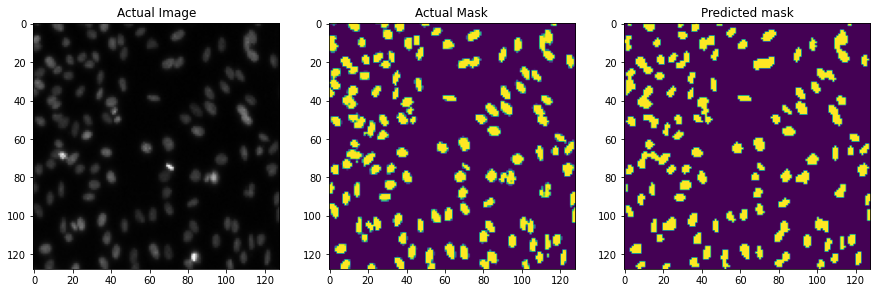

In [30]:
pred = model.predict(np.array(x_test_slices))
pred_t = (pred >0.5).astype('uint8')

for plot_image in range(3):
    random_image = np.random.randint(0, len(x_test_slices))
    plot_predicted_image(np.array(x_test_slices)[random_image], np.array(y_test_slices)[random_image],  pred_t[random_image])

## Model 3

In this model we will try to use learning scheduler and let's see this makes any difference

In [31]:
def scheduler(epoch):
    if epoch <50:
        return 0.001
#     elif ( 30 <= epoch and epoch <=50):
#         return 0.001
    elif (50<= epoch and epoch <=70 ):
        return 0.0001
    
    elif (epoch>70):
        return 0.0001 
call_back = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=True)

In [32]:
model = get_model(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

start = time.time()

history = model.fit(train_tensor_ds, validation_data = valid_tensor_ds, epochs = 100, callbacks = [call_back], verbose=False)

end = time.time()

print(f'Time required for the execution is {end - start}')


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.

Epoch 00007: LearningRateScheduler setting learning rate to 0.001.

Epoch 00008: LearningRateScheduler setting learning rate to 0.001.

Epoch 00009: LearningRateScheduler setting learning rate to 0.001.

Epoch 00010: LearningRateScheduler setting learning rate to 0.001.

Epoch 00011: LearningRateScheduler setting learning rate to 0.001.

Epoch 00012: LearningRateScheduler setting learning rate to 0.001.

Epoch 00013: LearningRateScheduler setting learning rate to 0.001.

Epoch 00014: LearningRateScheduler setting learning rate to 0.001.

Epoch 00015: LearningRateScheduler setting lear

In [33]:
df1 = pd.DataFrame(history.history)
plot_train_valid_curcve(df1)

Check the prediction on test image

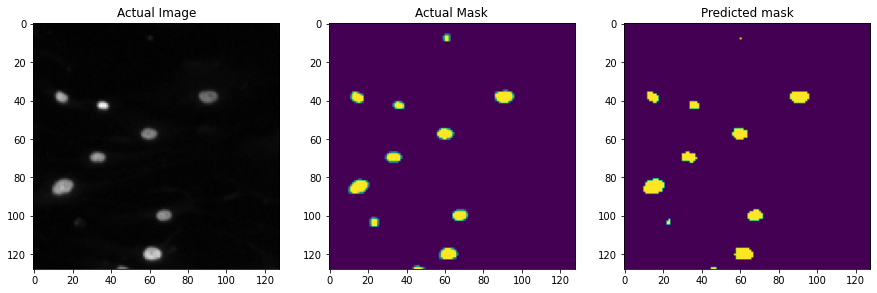

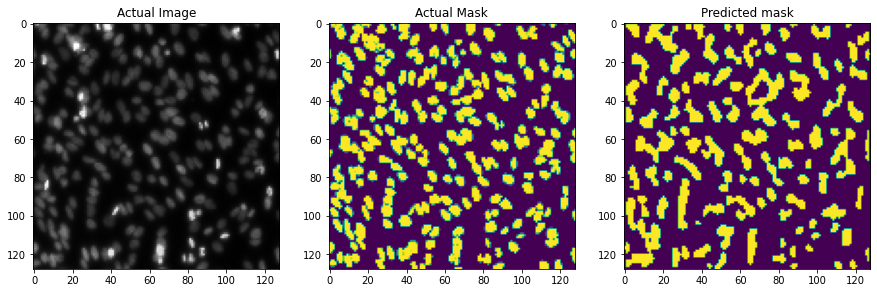

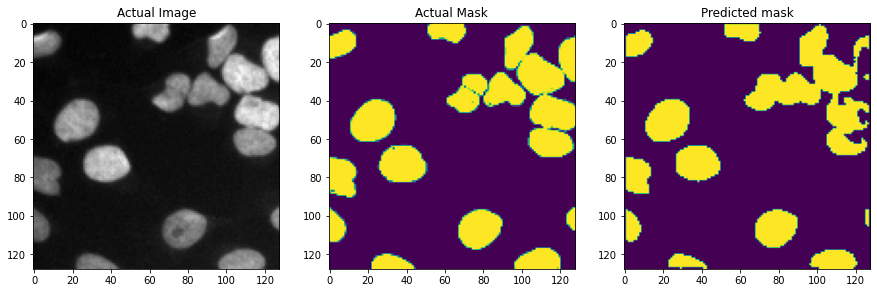

In [34]:
pred = model.predict(np.array(x_test_slices))
pred_t = (pred >0.5).astype('uint8')

for plot_image in range(3):
    random_image = np.random.randint(0, len(x_test_slices))
    plot_predicted_image(np.array(x_test_slices)[random_image], np.array(y_test_slices)[random_image],  pred_t[random_image])

This notebook gives us understandin how to proceed with image segmentation!! Please upvote if you like.
In next vesion I will use different loss function and accuracy metric.